# Projet DATA732 - Analyse et Visualisation de données

### LAURIANE KOALAGA et GNIDANHAN SORO

Dans ce projet, nous devions analyser un corpus d'articles.
Nous avons donc réalisé 3 dashboards.

In [1]:
import json
import plotly.express as px
from dash import Dash, dcc, html, Input, Output,State
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import dash
import plotly.graph_objects as go
from collections import defaultdict, Counter


c:\Users\rosys\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# PARTIE 1 : 
Comment évolue le nombre d'articles au fil des mois dans le corpus? et
Quels sont les 10 mots-clés les plus fréquents par année?



# Etape 1 : importation des données :

In [2]:
# nom du fichier
file_name = 'topaz-data732--mali--fr.sputniknews.africa--20190101--20211231.json'

# ouverture et téléchargement du fichier
f = open(file_name, 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

# Etape 2: Création du Dashboard 1

In [3]:
# Créer le Dash web application
app = Dash(__name__, suppress_callback_exceptions=True)

# Définir les années disponibles dans les données
years = list(data['data-all'].keys())

# Initialiser selected_year
selected_year = years[0]

# Créer la mise en page du tableau de bord
app.layout = html.Div(
    [
        html.H2("Top 10 Mots Clés Fréquents par Année"),
        html.Label("Sélectionner une année:"),
        dcc.Dropdown(
            id='year-dropdown',
            options=[{'label': year, 'value': year} for year in years],
            value=selected_year,  # Valeur par défaut
            clearable=False,  # Empêche la suppression de la sélection
        ),
        dcc.Graph(id='keyword-bar-chart'),
        html.Div(id='barchart-container'),
    ]
)

# Callback pour mettre à jour le graphique à barres en fonction de l'année sélectionnée
@app.callback(
    Output('keyword-bar-chart', 'figure'),
    Input('year-dropdown', 'value'),
    State('keyword-bar-chart', 'figure')
)
def update_keyword_bar_chart(selected_year, current_figure = None):
    # Filtrer les données pour l'année sélectionnée
    keywords_data = data['metadata-all']['fr']['year'][selected_year]['kws']
    
    sorted_dict = list(sorted(keywords_data.items(), key=lambda item: item[1], reverse=True))
    top_keywords = dict(sorted_dict[0:10])

    # Créer le bar chart interactif avec Plotly
    fig = px.bar(
        x=list(top_keywords.keys()),
        y=list(top_keywords.values()),
        labels={'x': 'Mots clés', 'y': 'Fréquence'},
        title=f'Top 10 Mots Clés Fréquents en {selected_year}'
    )
    
    return fig


# Callback pour mettre à jour le graphique des mots clés en fonction du mois survolé
@app.callback(
    Output('keyword-bar-chart', 'figure', allow_duplicate=True),
    Input('barchart-figure', 'hoverData'),
    Input('year-dropdown', 'value'),
    prevent_initial_call=True
)
def update_keywords_on_hover(hoverData, selected_year):

    if hoverData:
        # Extraire le mois survolé
        selected_month = hoverData['points'][0]['x']

        # Récupérer le dictionnaire de jours du mois sélectionné
        jours_mois_selectionne = data["data-all"][selected_year].get(selected_month, {})

        # Compter les occurrences des mots clés du mois sélectionné
        keywords_counter = Counter()
        for articles_jour in jours_mois_selectionne.values():
            for article_data in articles_jour:
                keywords_counter.update(article_data['kws'])

        # Sélectionner les 10 mots clés les plus fréquents
        mots_cles_frequents = dict(keywords_counter.most_common(10))

        # Créer le bar chart interactif avec Plotly pour les mots clés du mois sélectionné
        fig = px.bar(
            x=list(mots_cles_frequents.keys()),
            y=list(mots_cles_frequents.values()),
            labels={'x': 'Mots clés', 'y': 'Fréquence'},
            title=f'Top 10 Mots Clés Fréquents en {selected_year}, Mois {selected_month}'
        )

        return fig

    # Si aucune donnée n'est survolée, retournez le graphique initial
    return update_keyword_bar_chart(selected_year)



# Callback pour mettre à jour le graphique à barres en fonction de l'année sélectionnée
@app.callback(
    Output('barchart-container', 'children'),
    Input('year-dropdown', 'value')
)
def update_barchart(selected_year):
    result = {'month': [], 'count': []}
    for month in sorted(data["data-all"][selected_year].keys(), key=int):
        result['month'].append(month)
        compt = 0
        for day in data["data-all"][selected_year][month].keys():
            compt += len(data["data-all"][selected_year][month][day])
        result['count'].append(compt)

    fig = px.bar(result, x='month', y='count', title=f"Nombre d'articles par mois en {selected_year}")
    
    
    # Retournez le graphique mis à jour
    return dcc.Graph(figure=fig, id='barchart-figure')


# Exécuter l'application
if __name__ == "__main__":
    app.run_server(debug=True, port=8050)
 

# PARTIE 2 :

Quels sont les 10 mots clés associés aux 10 personnes les plus cités dans le corpus ?
Dans quels articles apparaissent les 10 personnes les plus fréquentes ? 

# Etape: création du dashboard 2

In [4]:

# Calcul des 10 personnes les plus fréquentes
persons_keywords = []

for year, months in data["data-all"].items():
    for month, days in months.items():
        for day, articles in days.items():
            for article in articles:
                if 'per' in article and 'kws' in article:
                    persons = article['per']
                    kws = list(article['kws'].keys())

                    for person in persons:
                        for kw in kws:
                            persons_keywords.append({'Personne': person, 'Mot-Clé': kw})

df = pd.DataFrame(persons_keywords)
counts = df.groupby(['Personne', 'Mot-Clé']).size().reset_index(name='Fréquence')
top_persons = counts.groupby('Personne').sum('Fréquence').nlargest(10, 'Fréquence').index.get_level_values('Personne').tolist()

# Initialisation de  l'application Dash
app = dash.Dash(__name__)

# Mise en page de l'application
app.layout = html.Div([
    dcc.Graph(id='heatmap-graph'), 
    dcc.Dropdown(
        id='personne-dropdown',
        options=[{'label': person, 'value': person} for person in top_persons],
        value=top_persons[0],  # Valeur par défaut
        multi=False
    ),
    dcc.DatePickerRange(
    id='date-picker-range',
    start_date='2019-01-01',
    end_date='2022-12-31',
    display_format='DD-MM-YYYY',  
    ),
    dcc.Graph(id='evolution-temporelle-graph'),
])

# Callback pour mettre à jour le graphique évolution temporelle pour la personne sélectionnée et de la plage de dates
@app.callback(
    Output('evolution-temporelle-graph', 'figure'),
    [Input('personne-dropdown', 'value'),
     Input('date-picker-range', 'start_date'),
     Input('date-picker-range', 'end_date')]
)
def update_evolution_temporelle_graph(selected_personne, start_date, end_date):
    articles_personne = []

    for year, months in data["data-all"].items():
        current_year = int(year)
        if current_year < int(start_date[:4]) or current_year > int(end_date[:4]):
            continue

        for month, days in months.items():
            for day, articles in days.items():
                for article in articles:
                    if 'per' in article and selected_personne in article['per']:
                        timestamp = article.get('timestamp', 0)
                        articles_personne.append({'Timestamp': timestamp, 'Article': article['title']})

    df_personne = pd.DataFrame(articles_personne)
    df_personne['Date'] = pd.to_datetime(df_personne['Timestamp'], unit='s')
    df_personne = df_personne.sort_values(by='Date')

    df_personne['Article_Numero'] = ['Article {}'.format(i + 1) for i in range(len(df_personne))]

    fig = go.Figure(go.Scatter(x=df_personne['Date'], y=df_personne['Article_Numero'], mode='markers',
                              text=df_personne[['Article_Numero', 'Article', 'Date']].apply(lambda x: f'{x[0]} - {x[1]} - {x[2].strftime("%d-%m-%Y")}', axis=1)))

    fig.update_traces(hovertemplate='%{text}')
    fig.update_layout(title=f'Évolution temporelle des articles pour {selected_personne}',
                      xaxis_title='Date', yaxis_title='Article')

    return fig

# Callback pour mettre à jour le graphique heatmap en fonction de l'ensemble des données
@app.callback(
    Output('heatmap-graph', 'figure'),
    [Input('personne-dropdown', 'value')]
)
def update_heatmap(selected_personne):
    persons_keywords = []

    for year, months in data["data-all"].items():
        for month, days in months.items():
            for day, articles in days.items():
                for article in articles:
                    if 'per' in article and 'kws' in article:
                        persons = article['per']
                        kws = list(article['kws'].keys())

                        for person in persons:
                            for kw in kws:
                                persons_keywords.append({'Personne': person, 'Mot-Clé': kw})

    df = pd.DataFrame(persons_keywords)
    counts = df.groupby(['Personne', 'Mot-Clé']).size().reset_index(name='Fréquence')

    top_persons = counts.groupby('Personne').sum('Fréquence').nlargest(10, 'Fréquence').index.get_level_values('Personne').tolist()
    top_keywords = counts.groupby('Mot-Clé').sum('Fréquence').nlargest(10, 'Fréquence').index.get_level_values('Mot-Clé').tolist()
    filtered_counts = counts[(counts['Personne'].isin(top_persons)) & (counts['Mot-Clé'].isin(top_keywords))]

    sorted_keywords = filtered_counts.sort_values(by='Fréquence', ascending=False)

    fig_heatmap = go.Figure(data=go.Heatmap(
        x=sorted_keywords['Personne'],
        y=sorted_keywords['Mot-Clé'],
        z=sorted_keywords['Fréquence'],
        colorscale='OrRd'))

    for personne, mot_cle, frequence in zip(sorted_keywords['Personne'], sorted_keywords['Mot-Clé'], sorted_keywords['Fréquence']):
        fig_heatmap.add_annotation(
            x=personne,
            y=mot_cle,
            text=str(frequence),
            showarrow=False,
            font=dict(color='black', size=10),
        )

    fig_heatmap.update_xaxes(type='category')
    fig_heatmap.update_layout(title='Heatmap des Personnes et Mots-Clés')

    return fig_heatmap

# Exécuter l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

# PARTIE 3 :

Est-ce possible de regrouper les articles du corpus en se basant sur les localisations qui y sont citées ?
De combien d’articles se compose donc chaque groupe formé ?
Quand on survole un cluster, quelles sont les 10 localisations les plus citées dans les articles appartenant au cluster survolé ?



# Etape 1: Clustering des articles en fonction des localisations

Extraction de toutes les localisations des articles du corpus :

In [5]:
def extractionLocalisations():
    dict_locs = {}

    for year in sorted(data['data-all'].keys(), key=int):
        for month in sorted(data['data-all'][year].keys(), key =int):
            for day in sorted(data['data-all'][year][month].keys(), key = int):
                new_key = year + '-' + month + '-' + day
                dict_locs[new_key] = {}  # Créer un dictionnaire vide pour chaque nouvelle clé
                
                for article in data['data-all'][year][month][day]:
                    # Vérifier si la clé 'loc' est présente dans l'article
                       if 'loc' in article.keys():
                           dict_locs[new_key] = article['loc']
    return list((dict_locs.values()))

   
#extractionLocalisations()





Vectorisation :

In [6]:
list_locs = extractionLocalisations() 
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(list_locs)

#print(X)


Determination du nombre optimal de cluster avec la méthode Silhouette :

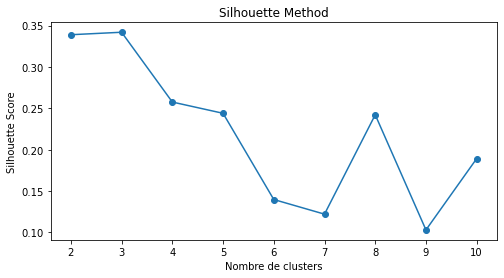

Le nombre optimal de clusters est : 3


In [7]:

# Silhouette
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracer la courbe de la silhouette
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Trouver le nombre de clusters avec le score de silhouette le plus élevé
best_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car on commence à partir de 2 clusters

# Afficher le résultat
print(f"Le nombre optimal de clusters est : {best_num_clusters}")



Application du modèle de clustering : K-Means

In [8]:
# Création du modèle de clustering 
kmeans = KMeans(n_clusters=best_num_clusters, random_state=5)
kmeans.fit(X)

# Ajouter les étiquettes de cluster aux données originales
for i, loc_dict in enumerate(list_locs):
    loc_dict['cluster'] = kmeans.labels_[i]

    #print(loc_dict)


In [9]:
# Obtenir le nombre total de clusters
num_clusters = max(kmeans.labels_) + 1

# Initialiser un dictionnaire par défaut pour stocker les localisations par cluster
clustered_locs = defaultdict(list)

# Collecter les localisations par cluster
for i, loc_dict in enumerate(list_locs):
    cluster_id = loc_dict['cluster']
    
    # Parcourir toutes les clés sauf 'cluster'
    for country, count in loc_dict.items():
        if country != 'cluster':
            clustered_locs[cluster_id].extend([country] * count)


Visualisation du Heatmap des centroïdes avec plotly :

In [10]:
# Obtenir les centres des clusters à partir du modèle KMeans
cluster_centers = kmeans.cluster_centers_

# Calculer la matrice de distance euclidienne entre les centres
distance_matrix = pd.DataFrame(np.linalg.norm(cluster_centers[:, np.newaxis] - cluster_centers, axis=-1))

# Créer une heatmap avec Plotly Express
heatmap_fig = px.imshow(
    distance_matrix,
    labels=dict(x='Cluster', y='Cluster', color='Distance'),
    x=list(range(distance_matrix.shape[1])),
    y=list(range(distance_matrix.shape[0])),
    color_continuous_scale="YlGnBu",
    title='Matrice de distance entre les centres (centroïdes) des clusters',
)

# Ajoutez des annotations pour afficher les valeurs dans les carrés
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        heatmap_fig.add_annotation(
            x=j,
            y=i,
            text=str(distance_matrix.iloc[i, j].round(3)),
            showarrow=False,
            font=dict(color='red')
        )

# Affichez la heatmap
#heatmap_fig.show()


# Etape 2 : Visualisation des articles par cluster 

In [11]:

# Créer un DataFrame avec les labels de cluster
df_clusters = pd.DataFrame({'cluster': kmeans.labels_})

# Compter le nombre d'articles par cluster
cluster_counts = df_clusters['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Créer un diagramme à barres avec Plotly Express
bar_chart_fig = px.bar(cluster_counts, x='cluster', y='count', labels={'cluster': 'Cluster', 'count': 'Nombre d\'articles'}, 
             title='Répartition des articles par cluster')





# Etape 3 : Extraction des localisations les plus citées du corpus 

In [12]:
loc_fig = None
def extractionLocalisation(loc_dict):
    global loc_fig  
    # Tri du dictionnaire des localisations par fréquence
    sorted_dict = list(sorted(loc_dict.items(), key=lambda item: item[1], reverse=True))
    
    # Séparer les 10 localisations et leurs fréquences
    top_locs = dict(sorted_dict[0:10])

    # Créer le bar chart interactif avec Plotly
    loc_fig = px.bar(x=list(top_locs.keys()), y=list(top_locs.values()), labels={'x': 'Localisations', 'y': 'Fréquence'},
                 title='Top 10 Localisations Fréquentes')
    
    # Afficher le graphique interactif
    #loc_fig.show()

# Utilisation de la fonction avec le dictionnaire des localisations de vos données
dictOfLocs = data["metadata-all"]["fr"]["all"]["loc"]
extractionLocalisation(dictOfLocs)

# Utilisation de la fonction avec le dictionnaire des localisations de vos données
list_locs = extractionLocalisations()


# Etape 4 : Création du Dashboard 3

In [13]:

# Créer le Dash web application
app = Dash(__name__, suppress_callback_exceptions=True)


# Créer la mise en page du tableau de bord
app.layout = html.Div(
    [   
        dcc.Graph(id='heatmap-graph', figure=heatmap_fig),
        dcc.Graph(id='bar-chart-graph', figure=bar_chart_fig),
        dcc.Graph(id='loc-graph', figure=loc_fig),
    ]
)

# Callback pour mettre à jour le graphique à barres des localisations en fonction du cluster sélectionné
@app.callback(
    Output('loc-graph', 'figure', allow_duplicate=True),
    Input('bar-chart-graph', 'hoverData'),
    prevent_initial_call=True
)
def update_loc_graph_hover(hover_data):
    if hover_data is not None:
        selected_cluster = hover_data['points'][0]['x']
        
        # Filtrer les données pour le cluster survolé
        loc_list = clustered_locs[selected_cluster]
        
        # Trouver les 10 localisations les plus fréquentes pour le cluster survolé
        loc_counter = Counter(loc_list)
        top_locs = dict(loc_counter.most_common(10))

        # Créer le bar chart interactif mis à jour avec Plotly
        updated_loc_fig_hover = px.bar(
            x=list(top_locs.keys()),
            y=list(top_locs.values()),
            labels={'x': 'Localisations', 'y': 'Fréquence'},
            title=f'Top 10 Localisations Fréquentes (Cluster {selected_cluster} - Survol)'
        )
        
        return updated_loc_fig_hover
    else:
        # Si aucune barre n'est survolée, afficher le graphique initial des localisations
        return loc_fig

# Exécuter l'application
if __name__ == "__main__":
    app.run_server(debug=True, port=8052)




C:\Users\rosys\AppData\Local\Temp\ipykernel_2720\3223185539.py:70: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\rosys\AppData\Local\Temp\ipykernel_2720\3223185539.py:70: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\rosys\AppData\Local\Temp\ipykernel_2720\3223185539.py:70: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\rosys\AppData\Local\Temp\ipykernel_2720\3223185539.py:70: FutureWarning:

Series.__getit